In [1]:
import os
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pandas.core.dtypes.common import is_numeric_dtype
from sklearn.feature_selection import mutual_info_regression, f_regression, SelectKBest
from sklearn.preprocessing import MinMaxScaler


In [2]:
DATA_FOLDER = 'dataset'
IMAGE_FOLDER = 'images'
DATASET = os.path.join(DATA_FOLDER, 'outliers_removed.csv')

In [3]:
df = pd.read_csv(DATASET)

categorical_attr_list = [col for col in df.columns if not is_numeric_dtype(df[col])]

# one hot encoding
df_reg = df.drop(columns=categorical_attr_list)
df_reg = df_reg.join(pd.get_dummies(df[categorical_attr_list], columns=categorical_attr_list).astype(int))

df_reg.head()

,frame_count,sum,mean,std,min,max,q01,q05,q25,q75,...,actor_actor_24,actor_actor_3,actor_actor_4,actor_actor_5,actor_actor_6,actor_actor_7,actor_actor_8,actor_actor_9,sex_F,sex_M
0,158558,0.145081,9.150000e-07,0.004001,-0.038422,0.040588,-0.012586,-0.005890,-0.000031,0.0,...,0,0,0,0,0,0,0,0,0,1
1,160160,0.114319,7.137790e-07,0.004283,-0.042603,0.048157,-0.013550,-0.006104,-0.000031,0.0,...,0,0,0,0,0,0,0,0,0,1
2,156956,0.149963,9.554485e-07,0.005084,-0.037018,0.058472,-0.015822,-0.007294,0.000000,0.0,...,0,0,0,0,0,0,0,0,0,1
3,152152,0.139618,9.176213e-07,0.004886,-0.036652,0.062683,-0.014923,-0.006714,-0.000031,0.0,...,0,0,0,0,0,0,0,0,0,1
4,169769,0.137665,8.108948e-07,0.002956,-0.026245,0.026215,-0.009399,-0.004364,-0.000031,0.0,...,0,0,0,0,0,0,0,0,0,1


# sc_min

## xgboost

In [4]:
TARGET = 'sc_min'

# drop quantile columns with high percentage of zeros (20%)
zero_percentage = (df_reg == 0).mean()
to_drop = [col for col in df_reg.columns if zero_percentage[col] > 0.2 and re.search(r'q\d{2}', col)]
df_reg = df_reg.drop(columns=to_drop)
to_drop

['mfcc_q50',
 'sc_q01',
 'sc_q05',
 'stft_q01',
 'stft_q05',
 'mfcc_q25_w1',
 'mfcc_q50_w1',
 'sc_q01_w1',
 'sc_q05_w1',
 'sc_q25_w1',
 'stft_q05_w1',
 'q50_w2',
 'q50_w3',
 'lag1_q50_w3',
 'q75_w4']

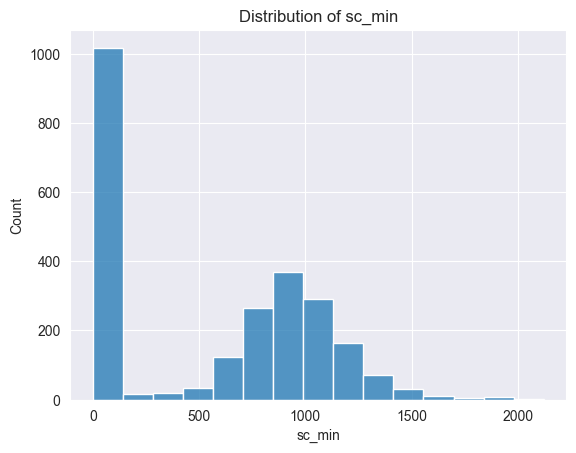

In [5]:
sns.histplot(data=df, x=df[TARGET])
plt.xlabel(f'{TARGET}')
plt.ylabel('Count')
plt.title(f'Distribution of {TARGET}')
plt.savefig(os.path.join(IMAGE_FOLDER, 'initial_sc_min_distr.pdf'), format='pdf')
plt.show()

In [6]:
from sklearn.model_selection import train_test_split

# rows to be fixed, do not reset indexes!
df_zero = df_reg[df_reg[TARGET] == 0]
df_nz = df_reg[df_reg[TARGET] != 0].reset_index(drop=True)

# dataframe has been one hot encoded
split_index = df_nz.index[df_nz['actor_actor_19'] == 1][0]

df_train = df_nz[:split_index]
df_test = df_nz[split_index:]

df_train, df_valid = train_test_split(df_train, test_size = 0.2, random_state = 100)

y_train = df_train[TARGET].to_numpy()
y_valid = df_valid[TARGET].to_numpy()
y_test = df_test[TARGET].to_numpy()

df_zero = df_zero.drop([TARGET], axis = 1)
df_train = df_train.drop([TARGET], axis = 1)
df_valid = df_valid.drop([TARGET], axis = 1)
df_test = df_test.drop([TARGET], axis = 1)

X_to_pred = df_zero.to_numpy()
X_train = df_train.to_numpy()
X_valid = df_valid.to_numpy()
X_test = df_test.to_numpy()

print(X_train.shape, X_valid.shape, X_test.shape, X_to_pred.shape)

(846, 269) (212, 269) (361, 269) (1010, 269)


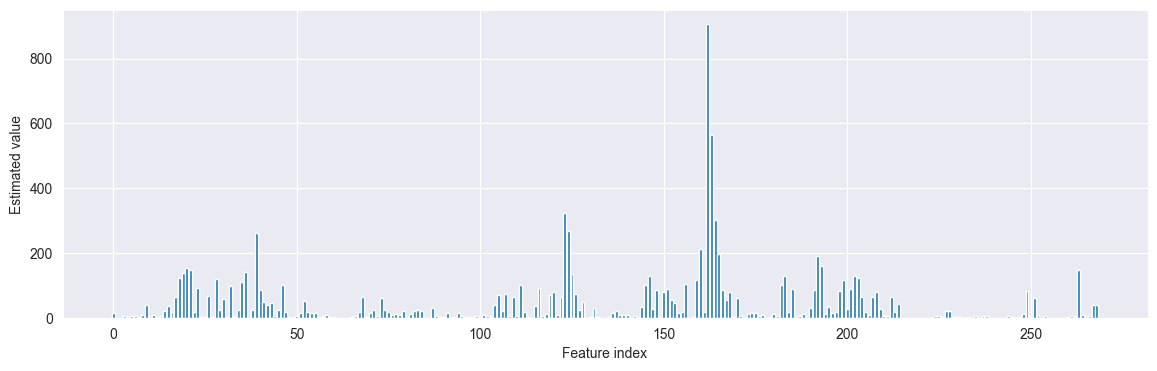

In [7]:
f_selector = SelectKBest(score_func = f_regression, k = 'all')
f_selector.fit(X_train, y_train)

plt.figure(figsize = (14, 4))
plt.bar([i for i in range(len(f_selector.scores_))], f_selector.scores_)
plt.xlabel('Feature index')
plt.ylabel('Estimated value')
plt.savefig(os.path.join(IMAGE_FOLDER, 'kbest_features_sc_min.pdf'), format='pdf')
plt.show()

In [8]:
f_selector = SelectKBest(score_func = f_regression, k = 10)
f_selector.fit(X_train, y_train)

X_train = f_selector.transform(X_train)
X_valid = f_selector.transform(X_valid)
X_test = f_selector.transform(X_test)
X_to_pred = f_selector.transform(X_to_pred)

# selected columns
selected_indices = f_selector.get_support(indices=True)
df_train.iloc[:, selected_indices]

,sc_q25,sc_q01_w2,sc_q05_w2,sc_mean_w3,sc_q01_w3,sc_q05_w3,sc_q25_w3,sc_q50_w3,mfcc_q50_w4,mfcc_q75_w4
259,1872.045102,1347.960576,1489.921327,1931.184503,1116.033592,1212.215438,1358.020500,1705.257250,0.165307,5.577283
157,2942.585558,1315.135357,1398.629908,2714.163426,823.486138,876.608240,1584.232512,2367.455035,7.206193,11.505003
666,1477.785981,705.138194,803.412355,1586.829664,937.444068,1053.909013,1259.824092,1496.566031,3.266991,9.129665
706,2616.879637,1186.732413,1546.434254,2361.227663,988.643551,1105.591378,1448.774492,1880.027363,0.558810,6.666757
125,3164.267715,1922.775674,2251.552376,2756.381107,1443.575892,1506.453749,2063.945834,2391.521167,3.373528,9.452036
...,...,...,...,...,...,...,...,...,...,...
802,1447.006395,972.964181,1133.025609,1496.474886,953.778425,999.396313,1126.115661,1491.674224,2.824193,7.795373
53,2216.479721,1536.245331,1762.329375,2479.108157,1465.527018,1518.101121,1829.542363,2254.740811,6.565955,13.692080
350,2020.566161,816.142082,985.926651,1979.083854,734.623135,875.756307,1500.137052,1712.007396,6.325346,12.997786
79,2962.181835,1481.238762,1942.911298,2912.952890,1296.712995,1412.026850,1994.622272,2565.782790,-0.111700,7.964514


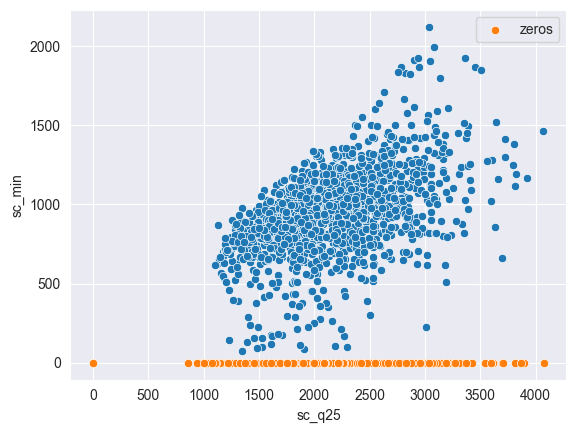

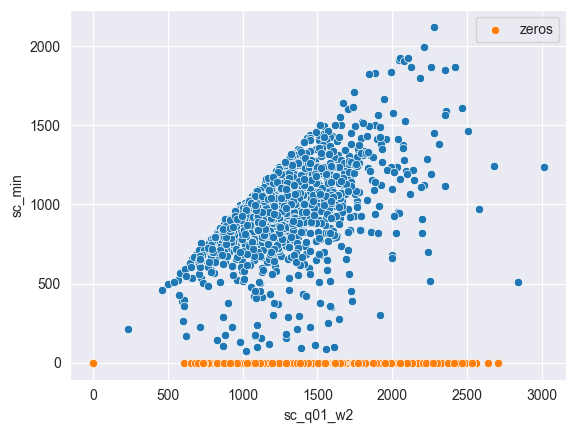

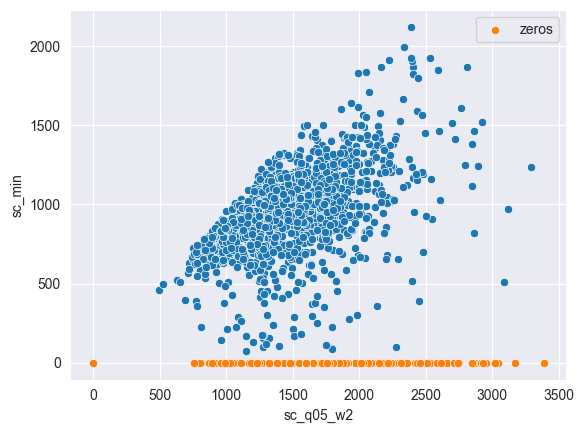

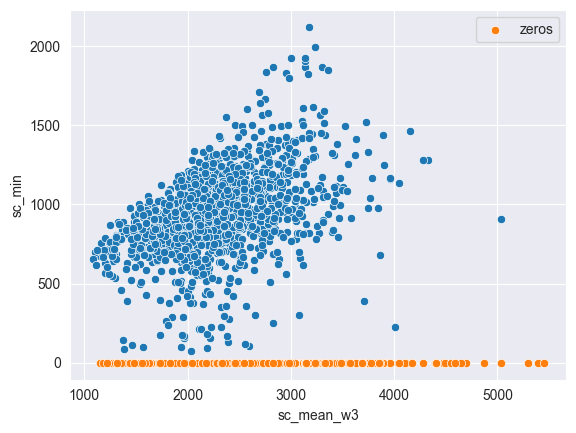

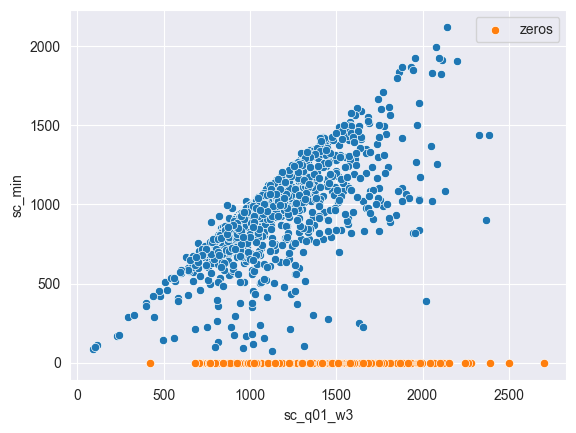

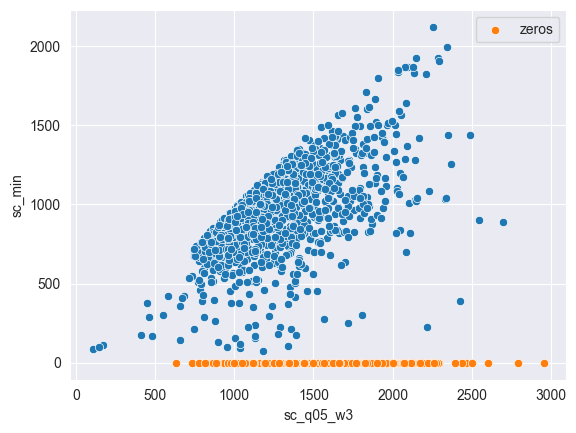

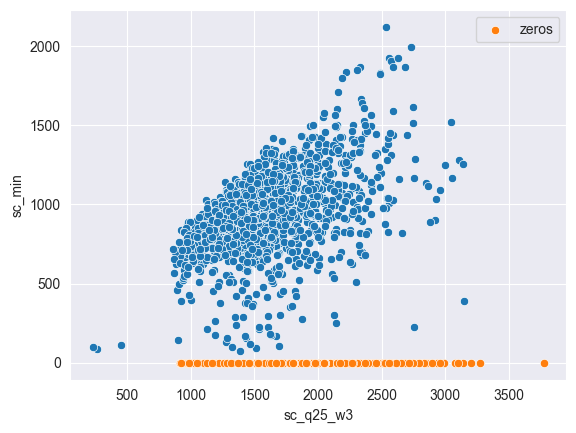

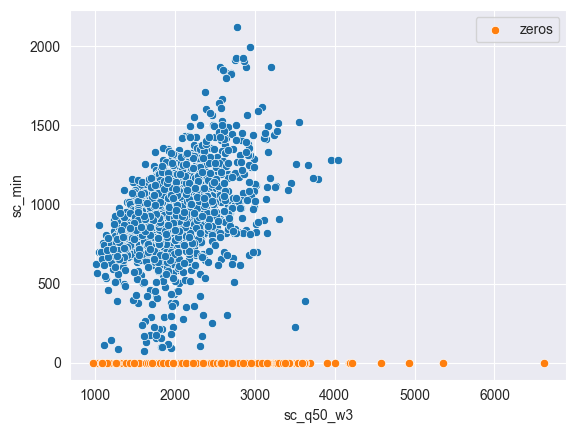

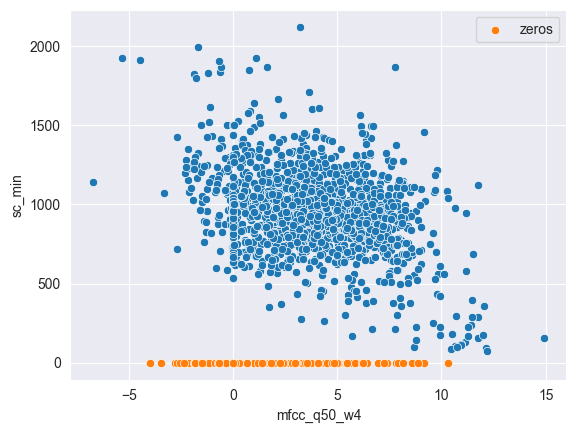

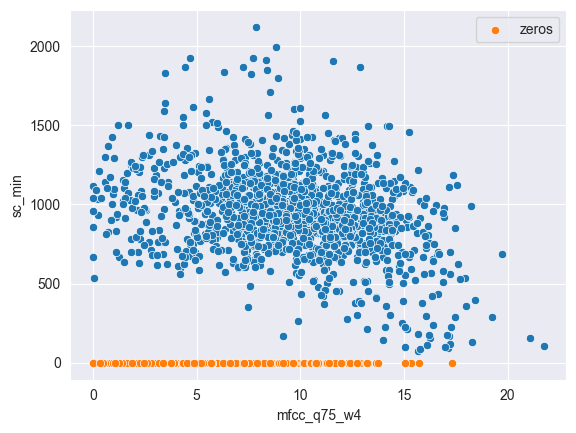

In [9]:
cols=list(df_train.iloc[:, selected_indices].columns)

for col in cols:
    sns.scatterplot(data = df_reg, y = TARGET, x = col)
    sns.scatterplot(data = df_reg[df_reg[TARGET] == 0], y = TARGET, x = col, label = 'zeros')
    plt.legend()
    plt.show()

In [10]:
#NB ha senso fare il minmaxscaler qui??
"""
scaler = MinMaxScaler()

y_train = scaler.fit_transform(y_train.reshape(-1, 1))
y_valid = scaler.fit_transform(y_valid.reshape(-1, 1))
y_test = scaler.fit_transform(y_test.reshape(-1, 1))

X_train = scaler.fit_transform(X_train)
X_valid = scaler.fit_transform(X_valid)
X_test = scaler.fit_transform(X_test)
X_to_pred = scaler.fit_transform(X_to_pred)"""

'\nscaler = MinMaxScaler()\n\ny_train = scaler.fit_transform(y_train.reshape(-1, 1))\ny_valid = scaler.fit_transform(y_valid.reshape(-1, 1))\ny_test = scaler.fit_transform(y_test.reshape(-1, 1))\n\nX_train = scaler.fit_transform(X_train)\nX_valid = scaler.fit_transform(X_valid)\nX_test = scaler.fit_transform(X_test)\nX_to_pred = scaler.fit_transform(X_to_pred)'

In [11]:
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
import optuna

# objective function to be minimized
def objective_fun(trial):

    booster = trial.suggest_categorical('booster', ['gbtree', 'dart'])
    gamma = trial.suggest_float('gamma', 0.001,0.1)
    max_depth = trial.suggest_int('max_depth',3, 20)
    min_child_weight = trial.suggest_float('min_child_weight', 0, 2)
    subsample = trial.suggest_float('subsample', 0.4, 1)
#     eta =  trial.suggest_float('eta', 0.3, 1)

    xgb = XGBRegressor(booster=booster, gamma=gamma, max_depth=max_depth, min_child_weight=min_child_weight, subsample=subsample)

    xgb.fit(X_train, y_train)
    y_pred = xgb.predict(X_valid)

    error = mean_squared_error(y_valid, y_pred)

    return error


study = optuna.create_study()
study.optimize(objective_fun, n_trials = 150, n_jobs = -1)

[I 2023-07-05 15:59:29,170] A new study created in memory with name: no-name-f828a350-b65a-4ee3-aef6-18a477ceb874
[I 2023-07-05 15:59:30,148] Trial 6 finished with value: 22215.72831003756 and parameters: {'booster': 'gbtree', 'gamma': 0.08395307111673497, 'max_depth': 4, 'min_child_weight': 0.45670551572697615, 'subsample': 0.6645940616991806}. Best is trial 6 with value: 22215.72831003756.
[I 2023-07-05 15:59:32,301] Trial 5 finished with value: 24814.038361858908 and parameters: {'booster': 'gbtree', 'gamma': 0.04682828953663765, 'max_depth': 14, 'min_child_weight': 1.048334162833912, 'subsample': 0.6823424480386487}. Best is trial 6 with value: 22215.72831003756.
[I 2023-07-05 15:59:32,746] Trial 4 finished with value: 22471.391632029823 and parameters: {'booster': 'dart', 'gamma': 0.07518051385579898, 'max_depth': 3, 'min_child_weight': 0.8138521702761226, 'subsample': 0.8224835913336506}. Best is trial 6 with value: 22215.72831003756.
[I 2023-07-05 15:59:33,333] Trial 3 finished 

In [12]:
best_params = study.best_params

xgb = XGBRegressor(**best_params)
xgb.fit(X_train, y_train)

y_pred_test = xgb.predict(X_test)

nrmse = np.sqrt(mean_squared_error(y_test, y_pred_test)) / (np.max(y_test) - np.min(y_test))

print(best_params)
print('Normalized root mean squared error = %.4f' % nrmse)
print('R-squared = %.4f' % r2_score(y_test, y_pred_test))

{'booster': 'gbtree', 'gamma': 0.08250397626233813, 'max_depth': 9, 'min_child_weight': 0.8674470940540391, 'subsample': 0.898849601494061}
Normalized root mean squared error = 0.0733
R-squared = 0.6357


In [13]:
y_pred = xgb.predict(X_to_pred)
y_pred

array([ 824.1567,  821.5406,  878.9371, ..., 1421.6332, 1264.3444,
       1294.9998], dtype=float32)

In [14]:
df_zero[TARGET] = y_pred
df.update(df_zero)

Text(0.5, 1.0, 'Distribution of predicted sc_min ')

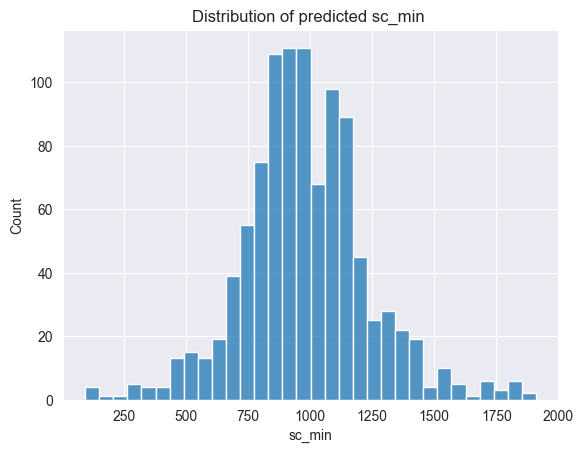

In [15]:
sns.histplot(data = df_zero, x = TARGET)
plt.title(f'Distribution of predicted {TARGET} ')

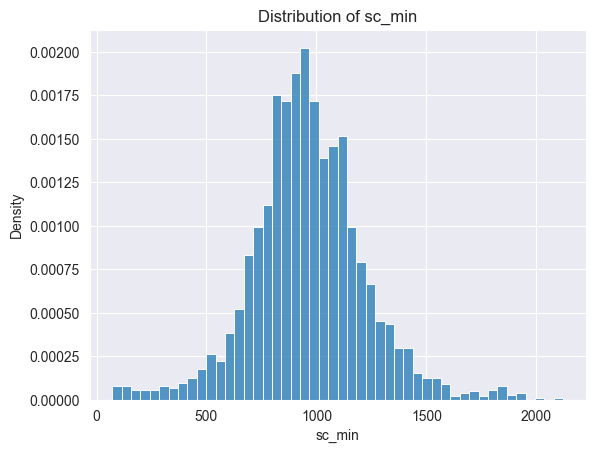

In [16]:
sns.histplot(data = df, x = TARGET, stat = 'density')
plt.xlabel(f'{TARGET}')
plt.ylabel('Density')
plt.title(f'Distribution of {TARGET}')
plt.savefig(os.path.join(IMAGE_FOLDER, 'xgboost_sc_min_distr.pdf'), format='pdf')
plt.show()

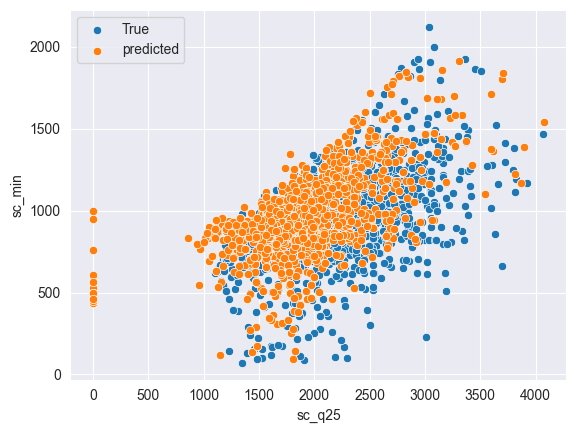

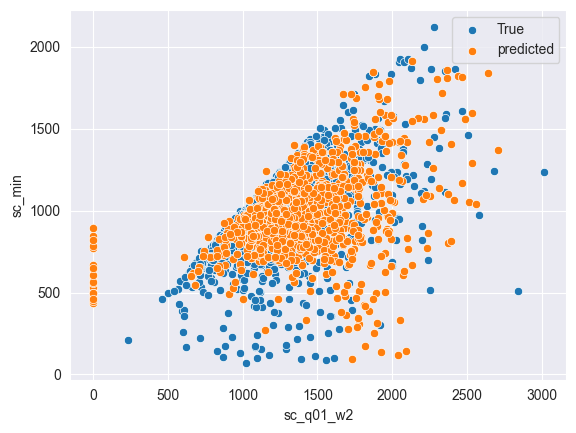

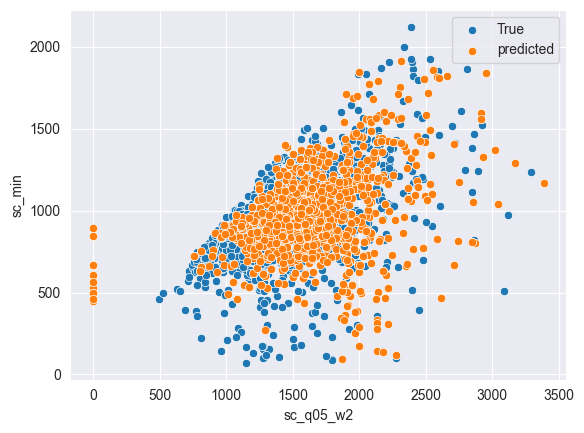

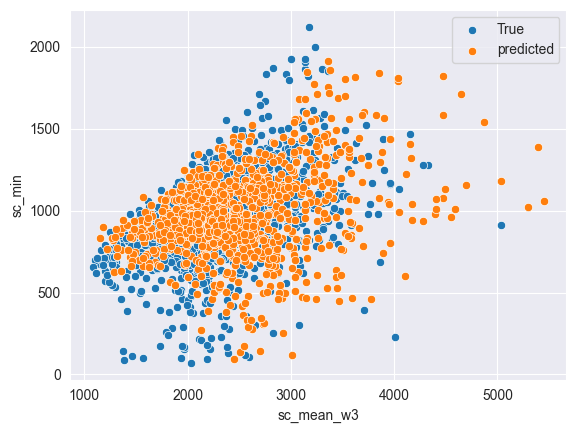

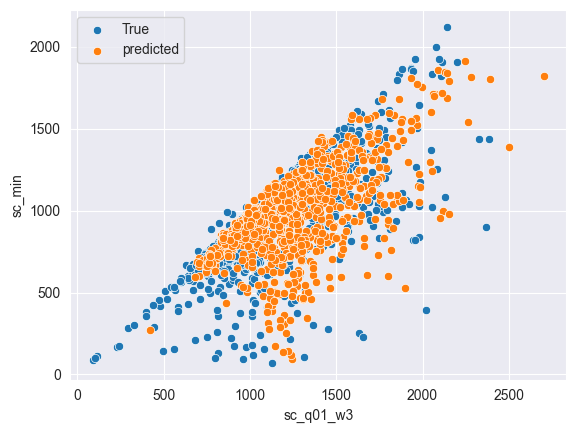

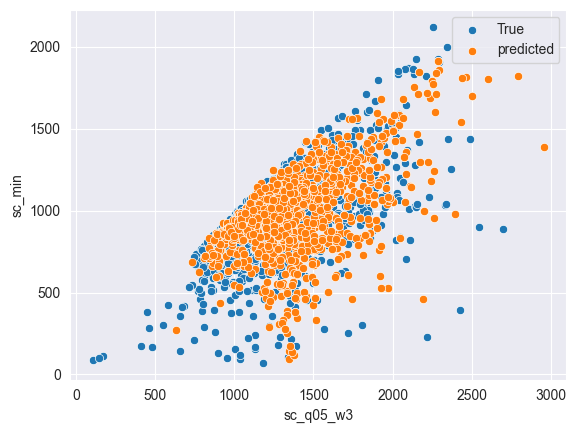

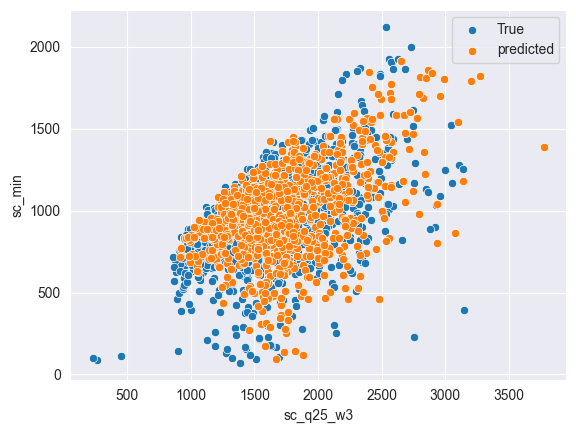

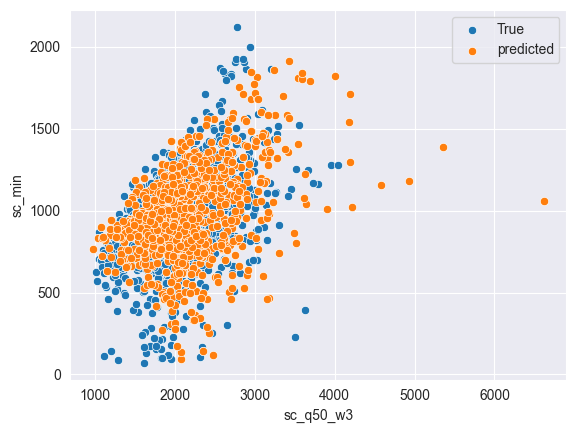

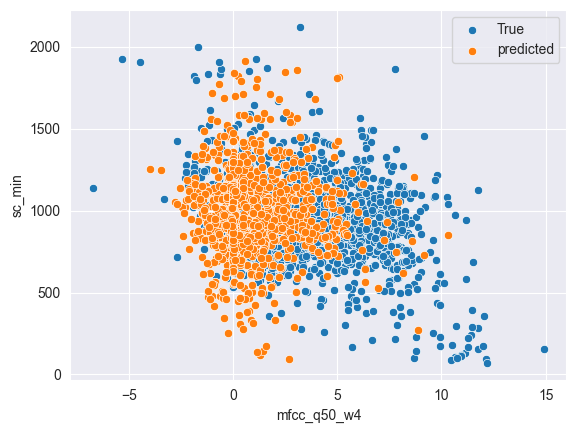

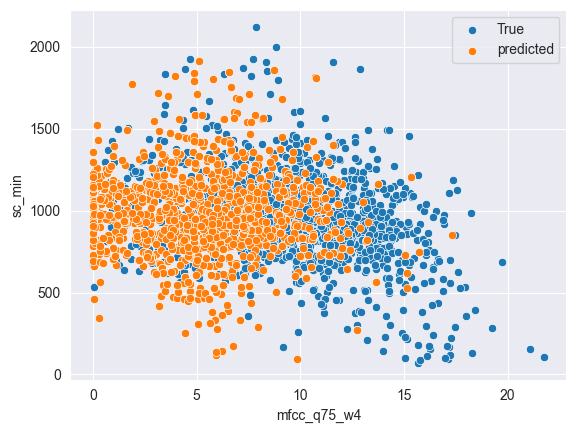

In [17]:
for col in cols:
    sns.scatterplot(data=df, y=TARGET, x=col, label='True')
    sns.scatterplot(data=df_zero,  y=y_pred, x=col, label='predicted')
    plt.legend()
    plt.show()

## random forest

In [18]:
from sklearn.ensemble import RandomForestRegressor

def objective_fun(trial):

    n_estimators = trial.suggest_int('n_estimators', 10,80)
    max_features = trial.suggest_categorical('max_features', ["auto", "sqrt", "log2"])
    min_samples_split = trial.suggest_int('min_samples_split', 3, 12)
    bootstrap = trial.suggest_categorical('bootstrap', [True, False])

    
    regr = RandomForestRegressor(bootstrap=bootstrap ,min_samples_split=min_samples_split ,max_features=max_features ,n_estimators=n_estimators)

    regr.fit(X_train, y_train)
    y_pred = regr.predict(X_valid)

    error = mean_squared_error(y_valid, y_pred)

    return error


study = optuna.create_study()
study.optimize(objective_fun, n_trials = 150, n_jobs = -1)

[I 2023-07-05 16:00:48,804] A new study created in memory with name: no-name-bda2ec01-e372-4e0d-876a-a2c0d72afcae
/Users/paolomollica/Desktop/DM2/venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/paolomollica/Desktop/DM2/venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/paolomollica/Desktop/DM2/venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been de

In [19]:
best_params = study.best_params

rf = RandomForestRegressor(**best_params)
rf.fit(X_train, y_train)

y_pred_test = rf.predict(X_test)

nrmse = np.sqrt(mean_squared_error(y_test, y_pred_test)) / (np.max(y_test) - np.min(y_test))

print(best_params)
print('Normalized root mean squared error = %.4f' % nrmse)
print('R-squared = %.4f' % r2_score(y_test, y_pred_test))

/Users/paolomollica/Desktop/DM2/venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


{'n_estimators': 69, 'max_features': 'auto', 'min_samples_split': 6, 'bootstrap': True}
Normalized root mean squared error = 0.0766
R-squared = 0.6015


In [20]:
y_pred = rf.predict(X_to_pred)
y_pred

array([ 844.71082424,  806.25534496,  878.14749585, ..., 1378.47296527,
       1256.88204224, 1258.59591249])

In [21]:
df_zero[TARGET] = y_pred
df.update(df_zero)

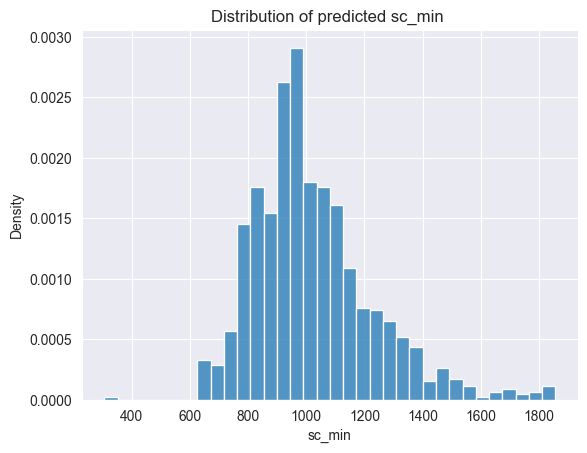

In [22]:
sns.histplot(data = df_zero, x = TARGET, stat = 'density')
plt.title(f'Distribution of predicted {TARGET} ')
plt.savefig(os.path.join(IMAGE_FOLDER, 'randforest_sc_min_distr.pdf'), format='pdf')


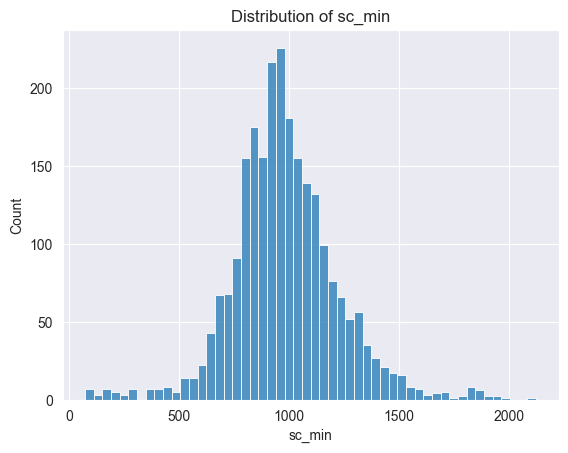

In [23]:
sns.histplot(data = df, x = TARGET)
plt.xlabel(TARGET)
plt.ylabel('Count')
plt.title(f'Distribution of {TARGET}')
plt.show()

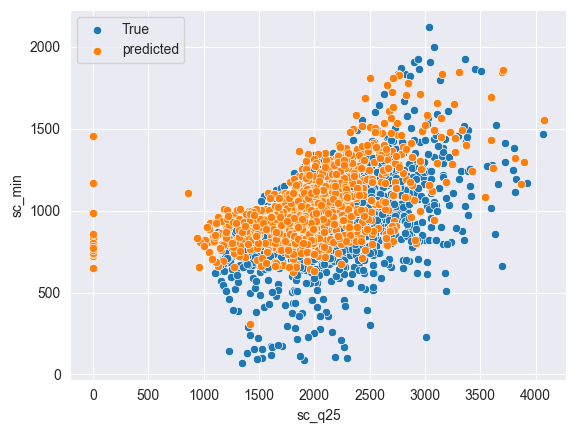

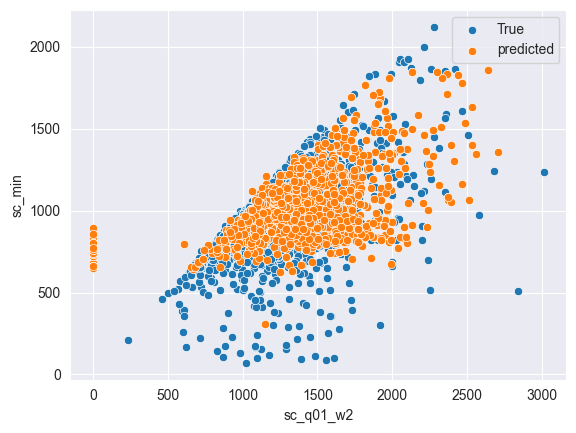

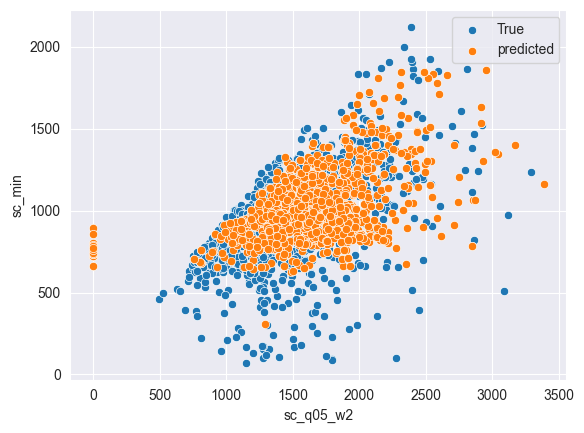

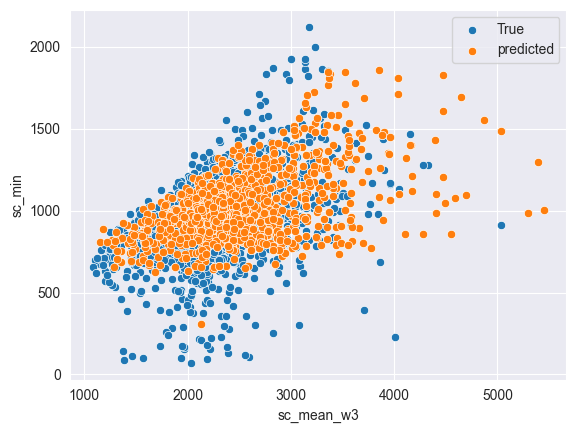

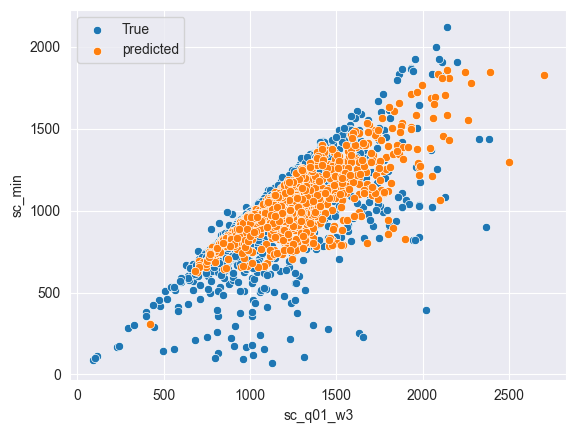

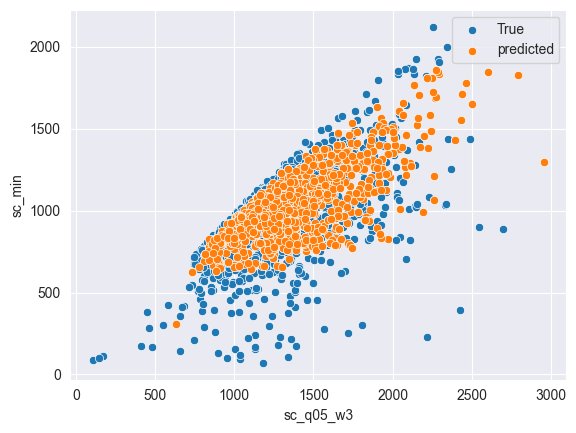

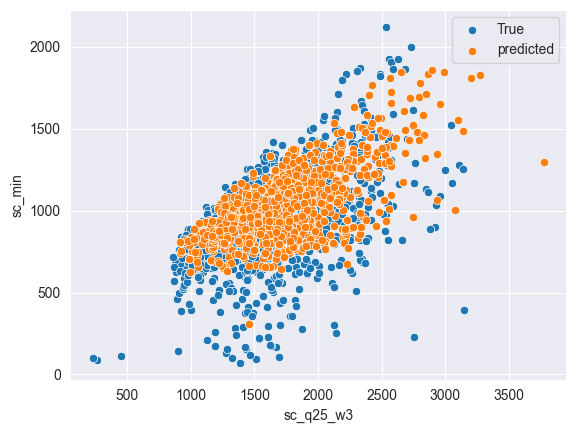

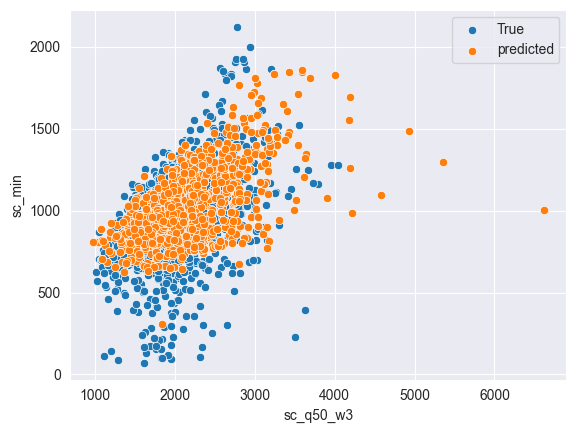

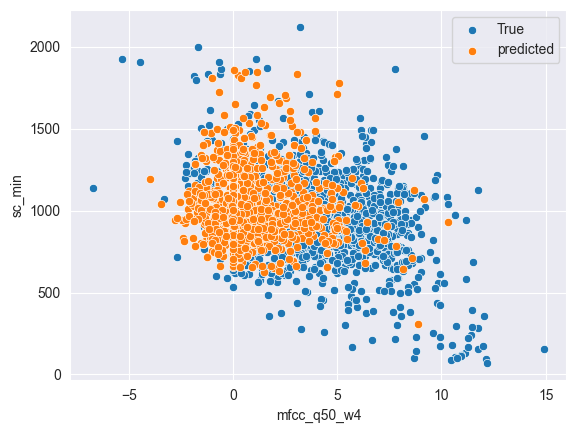

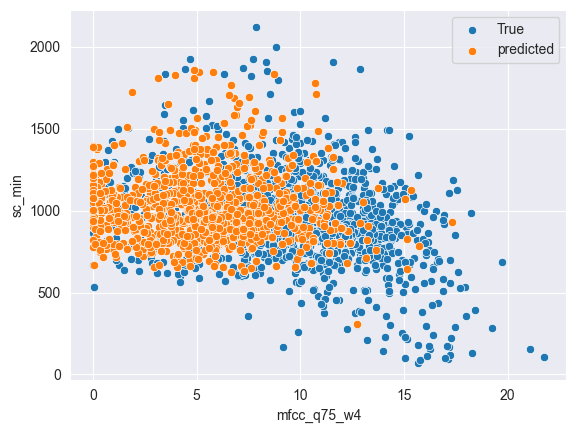

In [24]:
for col in cols:
    sns.scatterplot(data = df, y = TARGET, x = col, label = 'True')
    sns.scatterplot(data = df_zero,  y = y_pred, x = col, label = 'predicted')
    plt.legend()
    plt.show()